In [ ]:
import numpy as np
import time
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_main_path = '/content/gdrive/MyDrive/AllData/Xray_Dataset/'
def load_aug_data(batch_size=64):
    # Define a transform function that resizes images to 224x224
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                                  torchvision.transforms.ToTensor()])

    # Load training, validation and test data 
    train_data = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
    train_data = train_data + torchvision.datasets.ImageFolder(dataset_main_path+'Validation', transform=transform)
    #val_data = torchvision.datasets.ImageFolder(dataset_main_path+'Validation', transform=transform)
    test_data = torchvision.datasets.ImageFolder(dataset_main_path+'Test', transform=transform)
    #test_data = test_data + torchvision.datasets.ImageFolder(dataset_main_path+'Validation', transform=transform)

    # Training Data is augmented using three techniques
    aug_types = [torchvision.transforms.RandomRotation(40),                  
                torchvision.transforms.ColorJitter(brightness=([0.2, 1.8]),contrast=([0.5, 1.5]),saturation=([0.8, 1.2]),hue=([-.25, .25])), 
                torchvision.transforms.RandomHorizontalFlip(1)]

    # Create augmented training data
    end_index_1 = 512
    end_index_2 = 1024
    end_index_3 = 1536

    train_indices = [list(range(0, end_index_1)), 
                    list(range(end_index_1, end_index_2)), 
                    list(range(end_index_2, end_index_3))]

    for i in range(0,3):
        transform = torchvision.transforms.Compose([aug_types[i],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.ToTensor()])
        aug_dataset = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
        aug_dataset_subset = torch.utils.data.Subset(aug_dataset, train_indices[i])
        train_data_new = torch.utils.data.ConcatDataset([train_data, aug_dataset_subset])

    # The loaders with the augmented data
    train_loader = torch.utils.data.DataLoader(train_data_new, batch_size=batch_size, shuffle=True)
    #val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader




In [ ]:
bs = 1
trainLoader, testLoader = load_aug_data(batch_size=bs)
#testLoader = test[1]
print(len(trainLoader),len(testLoader))

4612 1024


In [ ]:
train_x = []
train_y = []

for x, y in trainLoader:
  train_x.append(x)
  train_y.append(y)

train_x = torch.stack(train_x)
train_y = torch.stack(train_y)
train_x = train_x.reshape(4612 , 224*224*3)
print(train_x.shape)
print(train_y.shape)

torch.Size([4612, 150528])
torch.Size([4612, 1])


In [ ]:
test_x = []
test_y = []
for x, y in testLoader:
  test_x.append(x)
  test_y.append(y)

test_x = torch.stack(test_x)
test_x = test_x.reshape(1024, 224*224*3)
test_y = torch.stack(test_y)
print(test_x.shape)
print(test_y.shape)

torch.Size([1024, 150528])
torch.Size([1024, 1])


In [ ]:
# Create a Gaussian Classfier
model = RandomForestClassifier(n_estimators = 220, criterion = 'gini', random_state = 20)
model.fit(train_x,train_y)
predict = model.predict(test_x)
value = accuracy_score(test_y,predict)
print(value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8193359375


[[0.93359375 0.03125    0.0234375  0.01171875]
 [0.0078125  0.95703125 0.01171875 0.0234375 ]
 [0.015625   0.0390625  0.7265625  0.21875   ]
 [0.01171875 0.12109375 0.20703125 0.66015625]]


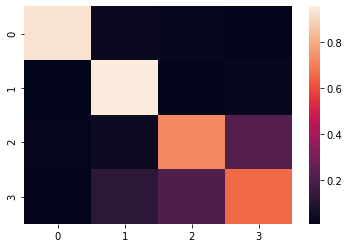

In [ ]:
labels = [0,1,2,3]
conf_mat = confusion_matrix(test_y, predict, normalize='true')
print(conf_mat)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(conf_mat)
plt.show()

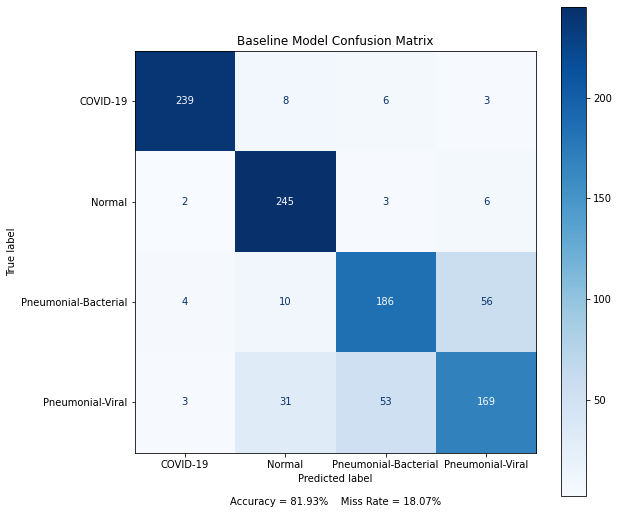

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
classes = ['COVID-19', 'Normal', 'Pneumonial-Bacterial', 'Pneumonial-Viral']
disp = plot_confusion_matrix(model, test_x, test_y,
                            display_labels=classes,
                            cmap=plt.cm.Blues, ax=ax, values_format = '.0f')

plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%    Miss Rate = {:0.2f}%'.format(value*100, 100*(1-value)))
plt.title('Baseline Model Confusion Matrix')
plt.show()

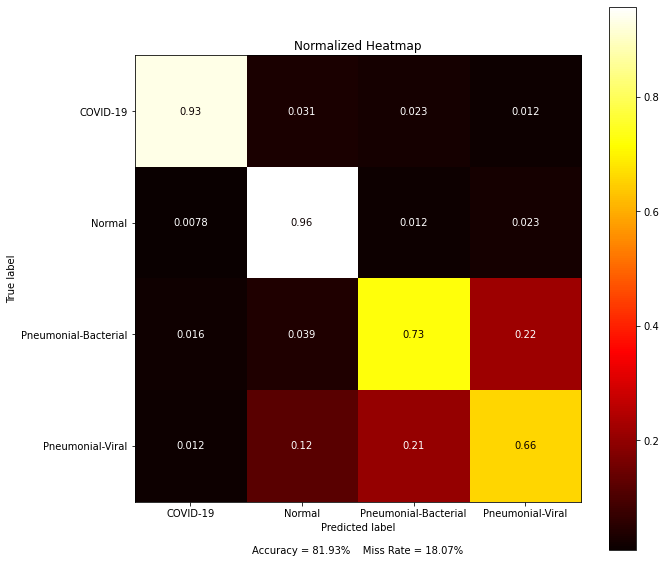

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
classes = ['COVID-19', 'Normal', 'Pneumonial-Bacterial', 'Pneumonial-Viral']
disp = plot_confusion_matrix(model, test_x, test_y,
                            display_labels=classes,
                            cmap=plt.cm.hot, ax=ax, normalize='true')
#disp.ax_.set_adjustable()
#print(disp.confusion_matrix)
plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%    Miss Rate = {:0.2f}%'.format(value*100, 100*(1-value)))
plt.title('Normalized Heatmap')
plt.show()

AUC for Class COVID-19: 1.00
AUC for Class Normal: 0.99
AUC for Class Pneumonial-Bacterial: 0.93
AUC for Class Pneumonial-Viral: 0.92


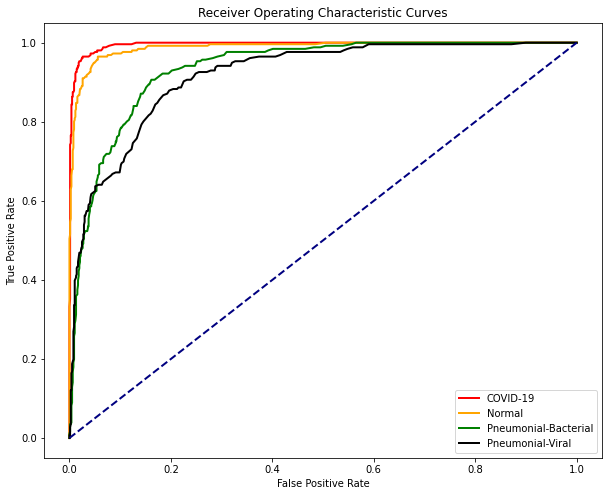

In [ ]:
#https://laurenliz22.github.io/roc_curve_multiclass_predictions_random_forest_classifier

score = model.predict_proba(test_x)
#y_test_bin = label_binarize(test_y, ['COVID-19', 'Normal', 'Pneumonial-Bacterial', 'Pneumonial-Viral'])
y_test_bin = label_binarize(test_y, [0,1,2,3])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

colors = ['red', 'orange', 'green', 'black']

plt.figure(figsize=(10, 8))

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], score[:, i])
  plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=classes[i])
  print('AUC for Class {}: {:0.2f}'.format(classes[i], auc(fpr[i], tpr[i])))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(classes)
plt.show()
